In [1]:
%matplotlib inline

import math
import random
import copy
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasagne
import theano
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.utils import shuffle
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from lasagne.layers import set_all_param_values

/home/ocamlmycaml/.local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Facial Key-Points detection

Taken from Kaggle (https://www.kaggle.com/c/facial-keypoints-detection): 

> The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:
> 1. tracking faces in images and video
> 2. analysing facial expressions
> 3. detecting dysmorphic facial signs for medical diagnosis
> 4. biometrics / face recognition
>
> Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.

In this project, we'll start with an EDA to identify important features, limitations and necessary transformations of our dataset. Then we will split the data into train, dev and test data to train models to evaluate different models.

## EDA

First we examine the data and types. Note that since there are a lot of columns, we've transponsed the rows here:

In [2]:
data = pd.read_csv('training.csv')
data.head(3).transpose()

,0,1,2
left_eye_center_x,66.0336,64.3329,65.0571
left_eye_center_y,39.0023,34.9701,34.9096
right_eye_center_x,30.227,29.9493,30.9038
right_eye_center_y,36.4217,33.4487,34.9096
left_eye_inner_corner_x,59.5821,58.8562,59.412
left_eye_inner_corner_y,39.6474,35.2743,36.321
left_eye_outer_corner_x,73.1303,70.7227,70.9844
left_eye_outer_corner_y,39.97,36.1872,36.321
right_eye_inner_corner_x,36.3566,36.0347,37.6781
right_eye_inner_corner_y,37.3894,34.3615,36.321


### Overview of data

In [3]:
pd.DataFrame({'type': data.dtypes})

,type
left_eye_center_x,float64
left_eye_center_y,float64
right_eye_center_x,float64
right_eye_center_y,float64
left_eye_inner_corner_x,float64
left_eye_inner_corner_y,float64
left_eye_outer_corner_x,float64
left_eye_outer_corner_y,float64
right_eye_inner_corner_x,float64
right_eye_inner_corner_y,float64


As it can be seen, each image has a vector of points for each facial feature. The Image itself has an `object` dtype, however, it appears to be a string when we access it. Let's convert it into a numpy array

In [4]:
print(type(data['Image'][0]))

<class 'str'>


In [5]:
data['Image_Matrix'] = data['Image'].apply(
    lambda x: np.array(x.split(' '), dtype=np.float)
)

data.head(3).transpose()

,0,1,2
left_eye_center_x,66.0336,64.3329,65.0571
left_eye_center_y,39.0023,34.9701,34.9096
right_eye_center_x,30.227,29.9493,30.9038
right_eye_center_y,36.4217,33.4487,34.9096
left_eye_inner_corner_x,59.5821,58.8562,59.412
left_eye_inner_corner_y,39.6474,35.2743,36.321
left_eye_outer_corner_x,73.1303,70.7227,70.9844
left_eye_outer_corner_y,39.97,36.1872,36.321
right_eye_inner_corner_x,36.3566,36.0347,37.6781
right_eye_inner_corner_y,37.3894,34.3615,36.321


Using this, we can plot some random images as examples

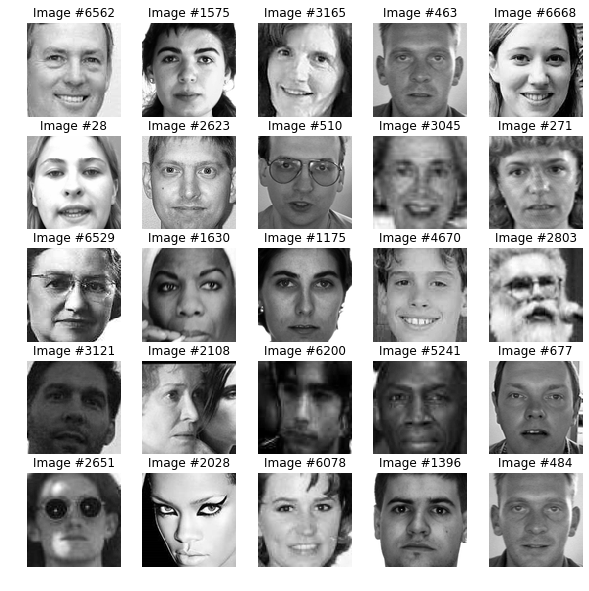

In [6]:
def plot_image_and_points(ax, image_vec, points_vec):
    ax.imshow(image_vec.reshape(96, 96), cmap='gray')
    if points_vec is not None:
        coords = points_vec.reshape((15, 2))
        ax.plot(coords[:, 0], coords[:, 1], 'rx')
        

def plot_random(dataset, nrows, ncols):
    #Plot a random array of faces
    face_ids = np.random.randint(low=0, high=len(dataset), size=(nrows*ncols))
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for face_id, ax in zip(face_ids, axes.ravel()):
        plot_image_and_points(ax, dataset[face_id], None)
        ax.set_title("Image #{}".format(face_id))
        ax.axis('off')


plot_random(
    dataset=data['Image_Matrix'],
    nrows=5,
    ncols=5
)

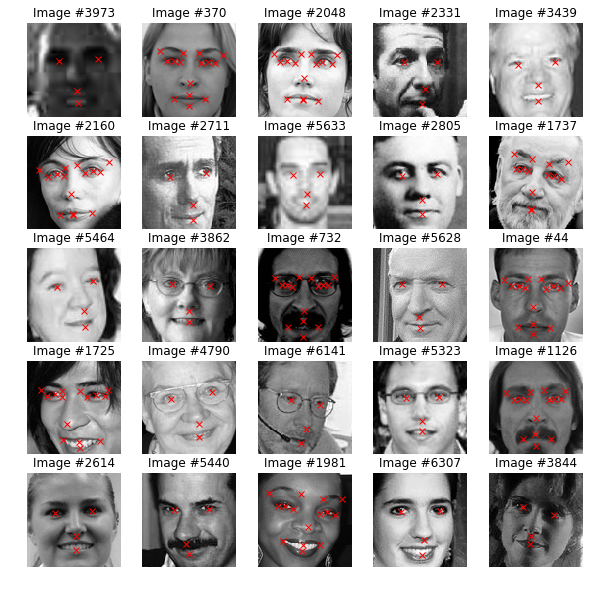

In [7]:
def plot_random_with_points(images, key_point_arrays, nrows, ncols):
    #Plot a random array of faces with markers
    face_ids = np.random.randint(low=0, high=len(images), size=(nrows*ncols))
    
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for face_id, ax in zip(face_ids, axes.ravel()):
        plot_image_and_points(ax, images[face_id], key_point_arrays[face_id])
        ax.set_title("Image #{}".format(face_id))
        ax.axis('off')


plot_random_with_points(
    images=data['Image_Matrix'],
    key_point_arrays=data.iloc[:, :-2].values,
    nrows=5,
    ncols=5
)

### Looking deeper into images

It appears as though a lot of images are grey-scaled photographs of real faces. They could have different expressions, and some even look at slightly different angles to the camera. However, it's worthwhile to note that all images seem to have the key-points within the frame of the image (more on that in the next section).

First, this is a good training example: centered, with all key points visible:

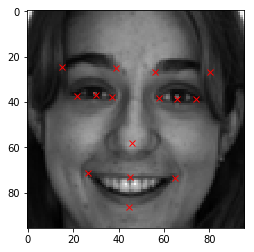

In [8]:
plot_image_and_points(plt, data['Image_Matrix'][1316], data.iloc[1316, :-2].values)

On the other hand, we have blurry or dark images with very few points visible

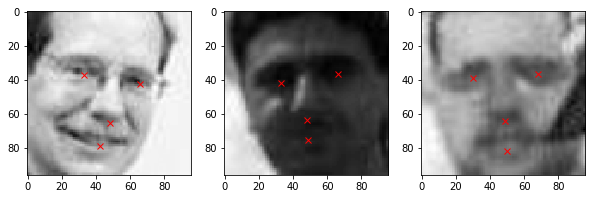

In [9]:
f, axes = plt.subplots(ncols=3, figsize=(10, 10))
for ax, face_id in zip(axes, [6232, 4703, 2909]):
    plot_image_and_points(ax, data['Image_Matrix'][face_id], data.iloc[face_id, :-2].values)

And then there are faces that are partially covered even though the visible key points are clear:

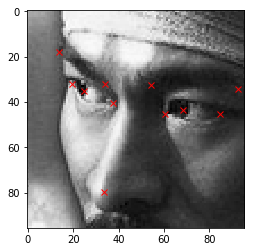

In [10]:
plot_image_and_points(plt, data['Image_Matrix'][1731], data.iloc[1731, :-2].values)

There are works of art in this data set as well. Some of these are faces from paintings, and as the fourth of the following examples show, they can be somewhat abstract or caricatural as well. Thus, we need to be robust to stylistic differences with how faces are depicted

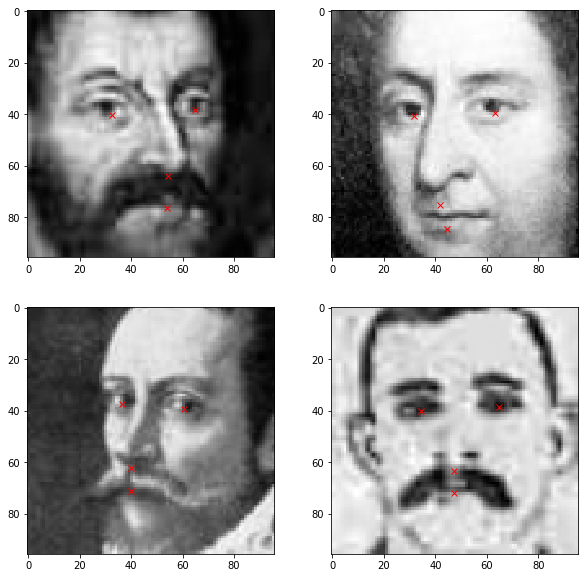

In [11]:
f, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for ax, face_id in zip(axes.ravel(), [2497, 5748, 3571, 4099]):
    plot_image_and_points(ax, data['Image_Matrix'][face_id], data.iloc[face_id, :-2].values)

Finally, we have a bunch of baby pictures. This shows age isn't a constant either

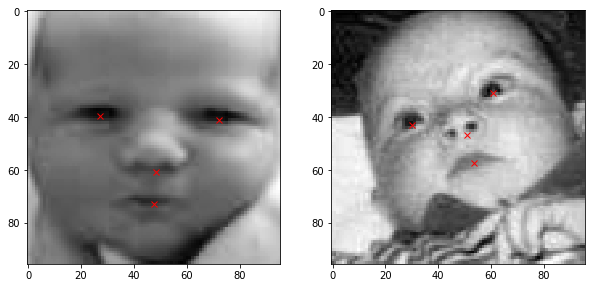

In [12]:
f, axes = plt.subplots(ncols=2, figsize=(10, 10))
for ax, face_id in zip(axes, [6136, 2831]):
    plot_image_and_points(ax, data['Image_Matrix'][face_id], data.iloc[face_id, :-2].values)

### Looking deeper into key points

As observed above, many key points are missing for a lot of images. This can also be seen in the counts in the summary here:

In [13]:
data.iloc[:, :-2].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
left_eye_center_x,7039.0,66.359021,3.448233,22.763345,65.082895,66.497566,68.024752,94.689280
left_eye_center_y,7039.0,37.651234,3.152926,1.616512,35.900451,37.528055,39.258449,80.502649
right_eye_center_x,7036.0,30.306102,3.083230,0.686592,28.783339,30.251378,31.768334,85.039381
right_eye_center_y,7036.0,37.976943,3.033621,4.091264,36.327681,37.813273,39.566729,81.270911
left_eye_inner_corner_x,2271.0,59.159339,2.690354,19.064954,58.039339,59.304615,60.519810,84.440991
left_eye_inner_corner_y,2271.0,37.944752,2.307332,27.190098,36.626283,37.878040,39.260348,66.562559
left_eye_outer_corner_x,2267.0,73.330478,3.405852,27.571879,71.716503,73.247824,75.015645,95.258090
left_eye_outer_corner_y,2267.0,37.707008,2.881438,26.250023,36.085523,37.639015,39.373489,64.618230
right_eye_inner_corner_x,2268.0,36.652607,2.350268,5.751046,35.506126,36.651562,37.753571,70.714966
right_eye_inner_corner_y,2268.0,37.989902,2.311907,26.250023,36.766783,37.944075,39.192917,69.808803


Box plots show the variance and mean of the available points. Here we can observe some patterns suggestive of correlation between some key points, and large variances among others:
1 - the x and y values for mouth key points have similar, though not perfectly same ranges
2 - y values of inner key points for the eyes are similar
3 - outer key points for mouth, eyebrow and eye aren't similar, but seem to have similar ranges around opposite parts of the image

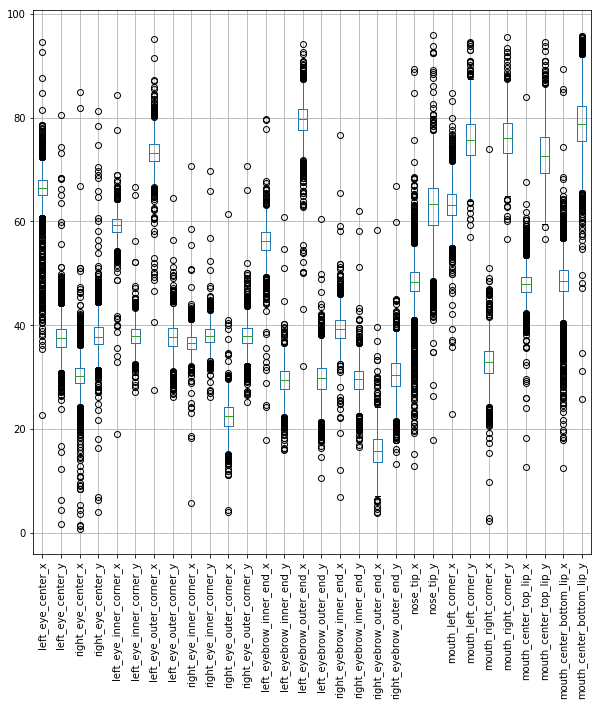

In [14]:
plt.figure(figsize=(10, 10))
data.iloc[:, :-2].boxplot()
plt.xticks(rotation=90);

Let's also look at a correlation matrix among those points. Here we can observe some cells have strong correlations above 0.8. Interestingly, most of the cells with more than 0.9 correlation appear to be y values like left-eye-inner-corner-y and left-eye-center-y. Correlations between similar x values aren't as strong and mostly appear to be in the range of 0.7-0.85. This could be because most of the faces seem to have good vertical orientation - most faces are straight and looking forward. However, most faces don't have consistent horizontal orientation with many people looking sideways into the camera.

In [15]:
data.iloc[:, :-2].corr().style.background_gradient()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
left_eye_center_x,1,0.0299075,0.274459,-0.154728,0.856572,0.0222112,0.879976,0.0621281,0.308649,-0.104698,-0.0650159,-0.0758572,0.631805,-0.128193,0.796638,-0.0711413,0.268463,-0.201853,-0.137146,-0.190548,0.457468,0.192274,0.422891,0.284087,-0.00838176,0.202842,0.260753,0.151302,0.374314,0.265655
left_eye_center_y,0.0299075,1,0.259012,0.346331,0.0657487,0.926728,-0.0134113,0.956066,0.101996,0.537101,0.152378,0.229097,0.0827237,0.609392,0.0573458,0.760461,0.22589,0.342458,0.194586,0.0708236,-0.166891,0.333053,-0.340755,0.480924,-0.392434,0.219366,-0.425576,0.251472,-0.37998,0.130062
right_eye_center_x,0.274459,0.259012,1,0.0676212,0.29455,0.127367,-0.0244079,0.0609424,0.817895,0.0902145,0.861858,0.0622925,0.301658,0.138773,-0.0633641,0.0834051,0.572767,0.137839,0.776246,0.0840069,0.402189,0.0245018,0.0611243,-0.172144,0.424439,-0.215123,0.308889,-0.109026,0.319541,-0.251105
right_eye_center_y,-0.154728,0.346331,0.0676212,1,-0.149295,0.53196,-0.144389,0.221829,0.0557581,0.92305,0.0785404,0.954285,-0.26256,0.366292,-0.240284,0.0930724,-0.121474,0.600844,-0.0153202,0.751725,0.182866,0.329233,0.312434,0.0980187,0.257956,0.397645,0.294145,0.198499,0.34401,0.0445971
left_eye_inner_corner_x,0.856572,0.0657487,0.29455,-0.149295,1,-0.0214444,0.653318,0.0804299,0.267661,-0.172852,0.248756,-0.106544,0.750635,-0.15282,0.622702,-0.0215916,0.372169,-0.258597,0.112094,-0.204863,0.387317,-0.054712,0.287427,0.156495,0.145968,0.0464387,0.322217,-0.0836353,0.242669,0.303769
left_eye_inner_corner_y,0.0222112,0.926728,0.127367,0.53196,-0.0214444,1,0.0105312,0.869743,0.150281,0.710354,0.104186,0.37134,-0.0114278,0.67713,0.035147,0.681814,0.180705,0.489169,0.130958,0.208522,-0.0910061,0.426897,-0.211855,0.493657,-0.335989,0.327081,-0.315929,0.387311,-0.367069,0.308555
left_eye_outer_corner_x,0.879976,-0.0134113,-0.0244079,-0.144389,0.653318,0.0105312,1,0.0541558,0.316254,-0.0942448,-0.350353,-0.077623,0.468184,-0.140902,0.868225,-0.0971674,0.22902,-0.200114,-0.336098,-0.213001,0.179189,0.165361,0.507755,0.325291,-0.136411,0.263466,0.229154,0.292129,0.176392,0.33288
left_eye_outer_corner_y,0.0621281,0.956066,0.0609424,0.221829,0.0804299,0.869743,0.0541558,1,0.0505289,0.373183,0.0908918,0.0604103,0.109101,0.522014,0.139029,0.802413,0.232601,0.188524,0.164726,-0.0694955,-0.176047,0.222928,-0.392594,0.506364,-0.462165,0.183239,-0.494482,0.21606,-0.561581,0.329316
right_eye_inner_corner_x,0.308649,0.101996,0.817895,0.0557581,0.267661,0.150281,0.316254,0.0505289,1,0.124023,0.543188,0.0749854,0.346247,0.137977,0.189012,0.0340235,0.657995,0.125718,0.521745,0.068031,0.377931,0.118548,0.262597,-0.0548881,0.262056,-0.0947484,0.36989,0.109785,0.309453,-0.230177
right_eye_inner_corner_y,-0.104698,0.537101,0.0902145,0.92305,-0.172852,0.710354,-0.0942448,0.373183,0.124023,1,0.054442,0.861327,-0.243664,0.515579,-0.183551,0.237008,-0.0463378,0.672297,-0.00377097,0.673633,0.0532115,0.356647,0.237858,0.225398,0.108121,0.449346,0.176403,0.354693,0.203002,0.164086


Here we can visualize the distribution of key points. The left image contains a sample of points to show how key points vary. The right image shows the average value of facial key points alone.

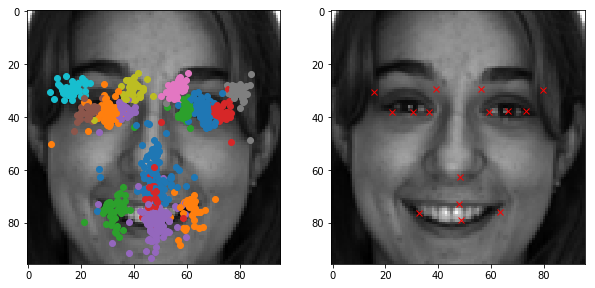

In [16]:
f, axes = plt.subplots(ncols=2, figsize=(10, 10))


# plot a sample of points
axes[0].imshow(data['Image_Matrix'][1316].reshape(96,96), cmap='gray')
for row_num in np.random.randint(len(data), size=100):
    row = data.iloc[row_num, :-2].values
    points = row.reshape(15, 2)
    for idx, point in enumerate(points):
        axes[0].scatter(point[0], point[1], color='C' + str(idx % 10))


# plot the mean values we computed above
plot_image_and_points(axes[1], data['Image_Matrix'][1316], data.iloc[:, :-2].mean().values)

We can visually support some of the observations we made earlier about correlations between different points

### Missing data:

It appears as though some rows also have some missing values for some columns 

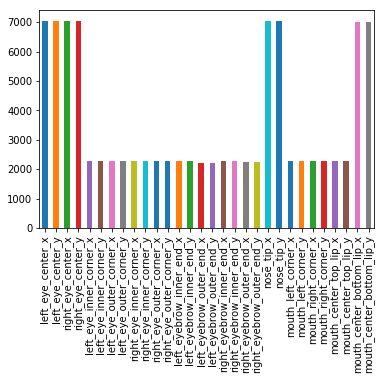

In [17]:
# Files appear to be organized with NaNs at the end
# plot a bar of values to position of the data
data.describe().loc['count'].plot.bar();

Particularly, we've noticed that the data in the lower rows tend to have missing values. Below is the first and last row of the dataset as examples:

,0,7048
left_eye_center_x,66.0336,66.9383
left_eye_center_y,39.0023,43.4245
right_eye_center_x,30.227,31.0961
right_eye_center_y,36.4217,39.5286
left_eye_inner_corner_x,59.5821,NaN
left_eye_inner_corner_y,39.6474,NaN
left_eye_outer_corner_x,73.1303,NaN
left_eye_outer_corner_y,39.97,NaN
right_eye_inner_corner_x,36.3566,NaN
right_eye_inner_corner_y,37.3894,NaN


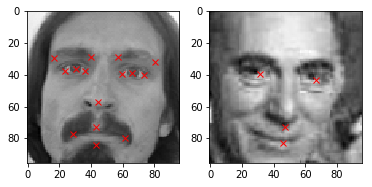

In [18]:
# first and last row plotted
f, axes = plt.subplots(nrows=1, ncols=2)
plot_image_and_points(axes[0], data['Image_Matrix'][0], data.iloc[0, :-2].values)
plot_image_and_points(axes[1], data['Image_Matrix'][len(data)-1], data.iloc[len(data)-1, :-2].values)

# dataframe for reference
data.iloc[[0, -1]].transpose()

This can be more clearly seen if we plot the different columns as a line graph, where x is the position in the dataframe

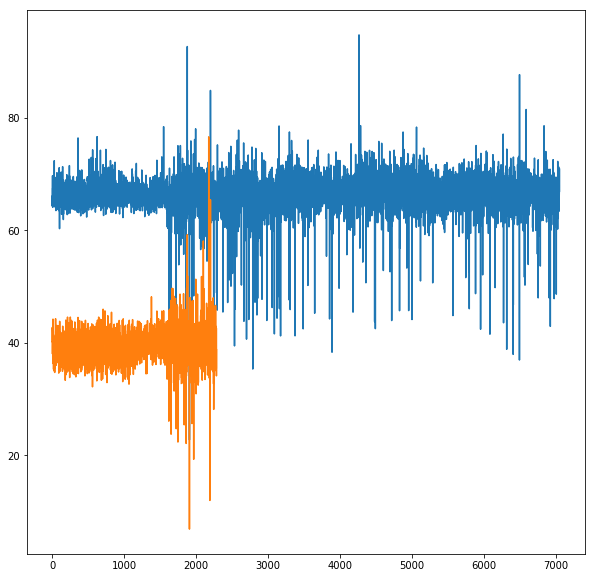

In [19]:
plt.figure(figsize=(10, 10))
plt.plot(data[['left_eye_center_x', 'right_eyebrow_inner_end_x']])
plt.show();

For the sake of this project, we're only using complete examples. Alternatively, we could have tried to model fewer facial key points, the ones that all rows contain, but we think that's a less interesting problem to solve. However, we certainly cannot impute key points in missing columns since they don't have  

We also have more than 2000 complete complete in our dataset

In [20]:
data = data.dropna()
len(data)

2140

### Summary

In Summary, images have a few quirks:
1. Many images had centered faces with all key points visible
2. Many are blurry images
3. Some don't have enough key points visible in the image
4. Many are artworks - so we need to remove stylistic features from our analyses as well
5. Age is not a factor

Key points are interesting in a few ways:
1. There are correlations among y-values of similar key points
2. There aren't many correlations among x-values

## Modelling

The loss function is RMSE. Here's a dataframe `all_results` to collect results, and a helper function to evaluate true and predicted values and store them in `all_results`

In [21]:
global all_results
all_results = pd.DataFrame({
    'method': [],
    'rmse': []
})

def measure_all(method_name, true, pred):
    global all_results
    all_results = all_results.append({
        'method': method_name,
        'rmse': math.sqrt(metrics.mean_squared_error(true, pred))
    }, ignore_index=True)
    
    # return it for displaying purposes
    return all_results

### Baseline - predicting the mean value for any image

This is a simple model that only predicts the same mean value for each test X value

In [22]:
class MeanValueModel():
    def __init__(self):
        self.means = None
        
    def fit(self, X, Y):
        self.means = np.apply_along_axis(np.mean, 0, Y)
        
    def predict(self, X):
        return np.tile(self.means, len(X)).reshape((len(X), len(self.means)))


baseline_train, baseline_test = train_test_split(data, test_size=0.2)

mvm = MeanValueModel()
mvm.fit(baseline_train['Image_Matrix'].values, baseline_train.iloc[:, :-2].values)

predicted = mvm.predict(baseline_test['Image_Matrix'].values)
predicted

array([[66.18390039, 36.83146796, 29.67057006, ..., 72.65289723,
        48.12363294, 82.58472077],
       [66.18390039, 36.83146796, 29.67057006, ..., 72.65289723,
        48.12363294, 82.58472077],
       [66.18390039, 36.83146796, 29.67057006, ..., 72.65289723,
        48.12363294, 82.58472077],
       ...,
       [66.18390039, 36.83146796, 29.67057006, ..., 72.65289723,
        48.12363294, 82.58472077],
       [66.18390039, 36.83146796, 29.67057006, ..., 72.65289723,
        48.12363294, 82.58472077],
       [66.18390039, 36.83146796, 29.67057006, ..., 72.65289723,
        48.12363294, 82.58472077]])

In [23]:
# since this is the first measurement we're doing, we set this as the all_results thing
measure_all('baseline', baseline_test.iloc[:, :-2].values, predicted)

,method,rmse
0,baseline,3.202738


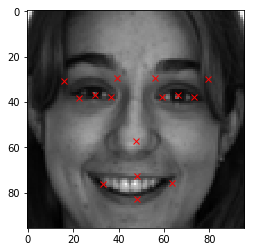

In [24]:
plot_image_and_points(
    plt,
    data['Image_Matrix'][1316],
    mvm.predict([data['Image_Matrix'][1316]])
)

### K-Nearest Regression - similar images might have similar key points

The intuition behind this model is that similar images would have similar key points. Thus, if we took the top k nearest images and averaged out the points, we should get a good guess of the key points on the tested image.

In [25]:
knr_train, _knr_temp = train_test_split(data, test_size=0.6)
knr_dev, knr_test = train_test_split(_knr_temp, test_size=0.5)

knr_train_X = [x for x in knr_train['Image_Matrix'].values]
knr_train_Y = [y for y in knr_train.iloc[:, :-2].values]
knr_dev_X = [x for x in knr_dev['Image_Matrix'].values]
knr_dev_Y = [y for y in knr_dev.iloc[:, :-2].values]

print(len(knr_train_X), len(knr_train_Y), len(knr_dev_X), len(knr_dev_Y))

856 856 642 642


The following code was used to identify the ideal k value, and it's computationally intensive so it's commented out and the last run is placed in the next cell

```python
print("Comparing mean square for different values of K")

for k in range(1, 11):
    knr_model = KNeighborsRegressor(n_neighbors=k)
    knr_model.fit(knr_train_X, knr_train_Y)
    
    predicted = knr_model.predict(knr_dev_X)
    score = metrics.mean_squared_error(knr_dev_Y, predicted)
    
    print("K => {}, MSE: {}".format(k, score))
```

It appears as though k=4 has the least mean squared error. In this case, let's measure again on the test set:

In [26]:
knr_model = KNeighborsRegressor(n_neighbors=4)
knr_model.fit(knr_train_X, knr_train_Y)
predicted = knr_model.predict([x for x in knr_test['Image_Matrix'].values])

measure_all('k-nearest regressor', knr_test.iloc[:, :-2].values, predicted)

,method,rmse
0,baseline,3.202738
1,k-nearest regressor,2.679292


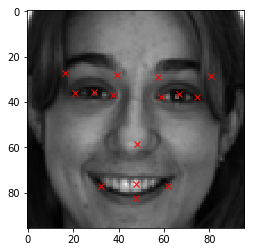

In [27]:
plot_image_and_points(
    plt,
    data['Image_Matrix'][1316],
    knr_model.predict([data['Image_Matrix'][1316]])
)

### K-Nearest Regression w/ Blurring - similar blurry images might have similar key points

This model augments a k-nearest regressor model by blurring the training data. The intuition is the same as above, except we allow more approximate similarity between test images and training points.

The blur function is below - it iterates through each pixel of an image and combines it with a weighted average of its neighboring 8 pixels

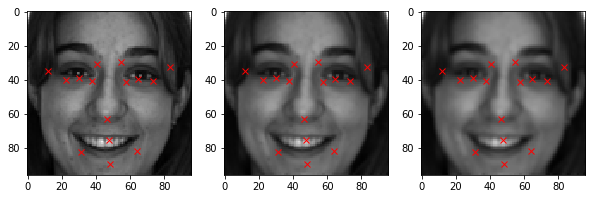

In [28]:
def apply_blur(vec, weight=(8.0/9.0)):
    
    # we need the weight of our neighbors to be less than 1
    assert weight <= 1.0
    
    img = np.reshape(vec, (96, 96))
    blurred_img = np.zeros((96, 96))
    
    # calculate the weight of the main pixel, and the weight of neighboring pixels
    # the default value of weight 8/9, gives equal weighting to all pixels
    center_weight = 1.0 - weight
    neighbor_weight = weight / 8
    
    # compute the blurred image (apologies for the inelegant code)
    # to keep things simple, we won't blur the edges. They're mostly black anyway
    for i in range(96):
        for j in range(96):
            if i == 0 or i == 95 or j == 0 or j == 95:
                pixel_value = img[i][j]
            else:
                pixel_value = center_weight * img[i][j]
                pixel_value += neighbor_weight * img[i-1][j-1]
                pixel_value += neighbor_weight * img[i-1][j]
                pixel_value += neighbor_weight * img[i-1][j+1]
                pixel_value += neighbor_weight * img[i][j-1]
                pixel_value += neighbor_weight * img[i][j+1]
                pixel_value += neighbor_weight * img[i+1][j-1]
                pixel_value += neighbor_weight * img[i+1][j]
                pixel_value += neighbor_weight * img[i+1][j+1]
            
            blurred_img[i][j] = pixel_value
    
    return np.reshape(blurred_img, 96 * 96)


f, axes = plt.subplots(ncols=3, figsize=(10, 30))

plot_image_and_points(axes[0], apply_blur(data['Image_Matrix'][1316], 0.0), data.iloc[1316, :-2].values)
plot_image_and_points(axes[1], apply_blur(data['Image_Matrix'][1316], 0.5), data.iloc[1316, :-2].values)
plot_image_and_points(axes[2], apply_blur(data['Image_Matrix'][1316], 0.9), data.iloc[1316, :-2].values)

In [29]:
from sklearn.neighbors import KNeighborsRegressor

knr_train, _knr_temp = train_test_split(data, test_size=0.6)
knr_dev, knr_test = train_test_split(_knr_temp, test_size=0.5)

knr_train_X = [x for x in knr_train['Image_Matrix'].values]
knr_train_Y = [y for y in knr_train.iloc[:, :-2].values]
knr_dev_X = [x for x in knr_dev['Image_Matrix'].values]
knr_dev_Y = [y for y in knr_dev.iloc[:, :-2].values]

print(len(knr_train_X), len(knr_train_Y), len(knr_dev_X), len(knr_dev_Y))

856 856 642 642


The following code was used to identify the ideal k and blur weight value, and it's computationally intensive so it's commented out and the last run is placed in the next cell

```python
print("Comparing mean square for different values of K and blur level")

blurrings = {
    b/10.0: [apply_blur(x, weight=b/10.0) for x in knr_train_X]
    for b in range(10)
}

best_k = None
best_blur_level = None
least_error = float('inf')
for k in range(1, 11):
    for blur_level in [b/10.0 for b in range(10)]:
        blurred_train_X = blurrings[blur_level]
        
        knr_model = KNeighborsRegressor(n_neighbors=k)
        knr_model.fit(blurred_train_X, knr_train_Y)
    
        predicted = knr_model.predict(knr_dev_X)
        mse = metrics.mean_squared_error(knr_dev_Y, predicted)
        
        if mse < least_error:
            best_k = k
            best_blur_level = blur_level
            least_error = mse
    
        print("K => {}, weight => {}, MSE: {}".format(k, blur_level, mse))
        
print("Best k: {}".format(best_k))
print("Blur_level: {}".format(best_blur_level))
print("Corresponding MSE: {}".format(least_error))
```

In [30]:
blurred_knr_train_X = [apply_blur(x, weight=0.9) for x in knr_train_X]

blurred_knr_model = KNeighborsRegressor(n_neighbors=6)
blurred_knr_model.fit(blurred_knr_train_X, knr_train_Y)
predicted = blurred_knr_model.predict([x for x in knr_test['Image_Matrix'].values])

measure_all('k-nearest regressor (with blurring)', knr_test.iloc[:, :-2].values, predicted)

,method,rmse
0,baseline,3.202738
1,k-nearest regressor,2.679292
2,k-nearest regressor (with blurring),2.666802


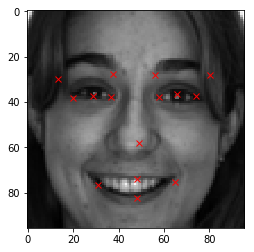

In [31]:
plot_image_and_points(
    plt,
    data['Image_Matrix'][1316],
    blurred_knr_model.predict([data['Image_Matrix'][1316]])
)

### Neural Network with Lasagne - Fully connected with hidden layer

In [32]:
train_data15_gah = data[data.columns[:-1]]

# Begin working with only the complete observations
# This removes some of the data, but eliminates the need for combining multiple models
# with different numbers of learned weights.

train_dataF_gah = copy.deepcopy(train_data15_gah)

#Convert the images to a manipulable array
train_dataF_gah['Image'] = train_dataF_gah['Image'].apply(lambda img:  np.fromstring(img, sep =' '))

#Create an array of the images
images_gah = np.vstack(train_dataF_gah['Image'].values)
#Scale the gray color from 0-1
images_gah = images_gah / 255.   
images_gah = images_gah.astype(np.float32)

#Create an array of the keypoints
keypoints_gah = train_data15_gah[train_data15_gah.columns[:-1]].values
#Scale the keypoints from -1, to pos 1 on the image
keypoints_gah = (keypoints_gah - 48) / 48 
keypoints_gah = keypoints_gah.astype(np.float32)

#Shuffle the training data
images_gah, keypoints_gah = shuffle(images_gah, keypoints_gah, random_state = 10)


Lasagne is a machine learning package built to run on Theano.  As it is still being developed some dependency 
issues still exist (many were encountered in model building).  The following models were run using the package
versions below:

theano 0.9.0  
Lasagne 0.2.dev1  
pygpu 0.6.9  
numpy 1.15.4  
scipy 0.19.1 

In [33]:
# Using the Lasagne to create a simple neural net with 3 layers (1 hidden).
# This model uses the Lasagne defaults of variable epoch sample size, a 20% validation split, and a MSE loss function

model1_gah = NeuralNet(
layers = [('input', layers.InputLayer), ('hidden', layers.DenseLayer),('output', layers.DenseLayer)],
input_shape=(None, 9216), hidden_num_units=100, output_nonlinearity=None, output_num_units=30,
update=nesterov_momentum, update_learning_rate=0.01, update_momentum=0.9, regression=True, max_epochs=500, verbose=1)


In [34]:
# # Model is trained using training data set of images with all 15 keypoints
# # Training steps are commented out here for runtime issues
# # Pickle is used to save model results for reloading
# model1_gah.fit(images, keypoints)

# with open('model1_gah.pickle', 'wb') as f:
#     pickle.dump(model1_gah, f, -1)
    
with open('model1_gah.pickle', 'rb') as f:
    model1_gah = pickle.load(f)

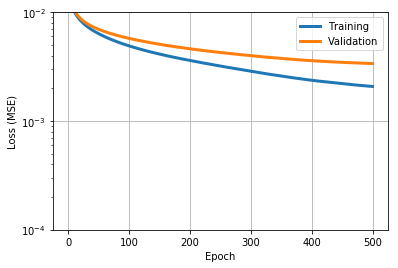

In [35]:
def plotloss(model):
    train_loss = np.array([i["train_loss"] for i in model.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in model.train_history_])
    plt.plot(train_loss, linewidth=3, label="Training")
    plt.plot(valid_loss, linewidth=3, label="Validation")
    plt.grid()
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.ylim(1e-4, 1e-2)
    plt.yscale("log")
    plt.show()
    
plotloss(model1_gah)

After 500 epochs the model is still (slowly) improving validation loss.  The final loss value is 0.00338 corresponding to a RMSE error of 2.79.

In [36]:
global all_results
all_results = all_results.append({
    'method': 'NN - fully connected',
    'rmse': 2.79
}, ignore_index=True)

all_results

,method,rmse
0,baseline,3.202738
1,k-nearest regressor,2.679292
2,k-nearest regressor (with blurring),2.666802
3,NN - fully connected,2.790000


### Neural Network - with convolutions

In [37]:
# Reshape the array of images to work with a 2D convolutional network
images2_gah = images_gah.reshape(-1, 1, 96, 96)

The next model incorporates Lasagne's convolution features to create a more complex model.  This includes 2D convolution layers, 2D pooling layers, and fully connected hidden layers.  This model architecture follows an example created by Daniel Nouri
(http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/).  # This model uses the Lasagne defaults of variable epoch sample size, a 20% validation split, and a MSE loss function.  

In [38]:
model2_gah = NeuralNet(
layers=[('input', layers.InputLayer),('conv1', layers.Conv2DLayer),('pool1', layers.MaxPool2DLayer),('conv2', layers.Conv2DLayer),
('pool2', layers.MaxPool2DLayer),('conv3', layers.Conv2DLayer),('pool3', layers.MaxPool2DLayer),('hidden4', layers.DenseLayer),
('hidden5', layers.DenseLayer),('output', layers.DenseLayer),],
input_shape=(None, 1, 96, 96),
conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
hidden4_num_units=500, hidden5_num_units=500, output_num_units=30, output_nonlinearity=None,

update_learning_rate=0.01,update_momentum=0.9,regression=True,max_epochs=500,verbose=1)

In [39]:
# # Model is trained using training data set of images with all 15 keypoints
# # Training steps are commented out here for runtime issues
# # Pickle is used to save model results for reloading

# model2_gah.fit(images2_gah, keypoints_gah)

# with open('model2_gah.pickle', 'wb') as f:
#     pickle.dump(model2_gah, f, -1)
    
with open('model2_gah.pickle', 'rb') as f:
    model2_gah = pickle.load(f)

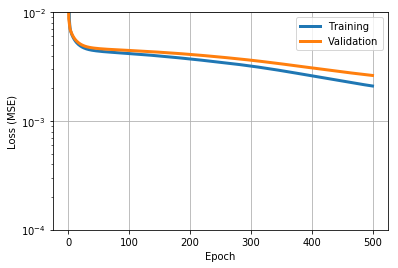

In [40]:
plotloss(model2_gah)

The convolution model improves faster than the simple model, but after 500 epochs the model has similar validation loss.  The final loss value is 0.00263 corresponding to a RMSE error of 2.46.  While providing an overall more accurate result, adding the convolution layers slowed the model considerable pushing the training time of the model to over 75 sec/ epoch.  As the validation loss is still improving there is a desire to allow the model to train longer.  The same layering is used, but the learning rate and momentum are changed to update throughout the training process. Again the training is commented out and the Pickled result is loaded.

In [41]:
def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.05, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
model3_gah = NeuralNet(
layers=[('input', layers.InputLayer),('conv1', layers.Conv2DLayer),('pool1', layers.MaxPool2DLayer),('conv2', layers.Conv2DLayer),
('pool2', layers.MaxPool2DLayer),('conv3', layers.Conv2DLayer),('pool3', layers.MaxPool2DLayer),('hidden4', layers.DenseLayer),
('hidden5', layers.DenseLayer),('output', layers.DenseLayer),],
input_shape=(None, 1, 96, 96),
conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
hidden4_num_units=500, hidden5_num_units=500, output_num_units=30, output_nonlinearity=None,

update_learning_rate=theano.shared(float32(0.05)),update_momentum=theano.shared(float32(0.9)),
regression=True,max_epochs=1000,
on_epoch_finished=[
AdjustVariable('update_learning_rate', start=0.05, stop=0.001),
AdjustVariable('update_momentum', start=0.9, stop=0.999)],verbose=1)

In [42]:
# # Model is trained using training data set of images with all 15 keypoints
# # Training steps are commented out here for runtime issues
# # Pickle is used to save model results for reloading

# model3_gah.fit(images2_gah, keypoints_gah)

# with open('model3_gah.pickle', 'wb') as f:
#     pickle.dump(model3_gah, f, -1)
    
with open('model3_gah.pickle', 'rb') as f:
    model3_gah = pickle.load(f)

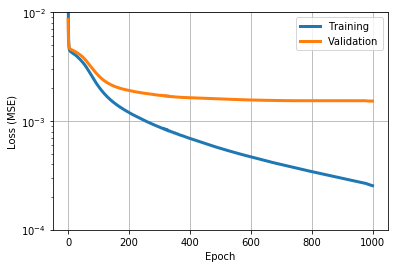

In [43]:
plotloss(model3_gah)

The final validation loss of .00153 corresponds to a RMSE of 1.88, an improvement over the previous models, but plotting the loss over training shows some troubling trends.  As expected the with a higher learning rate, the train and validation loss decrease quickly early in the training, but the validation loss plateaus early in the training process.  The training loss continues to decrease most likely indicating overfitting and the concern that the model would not generalize well to other data.  We load the test data to examine some predictions on it.

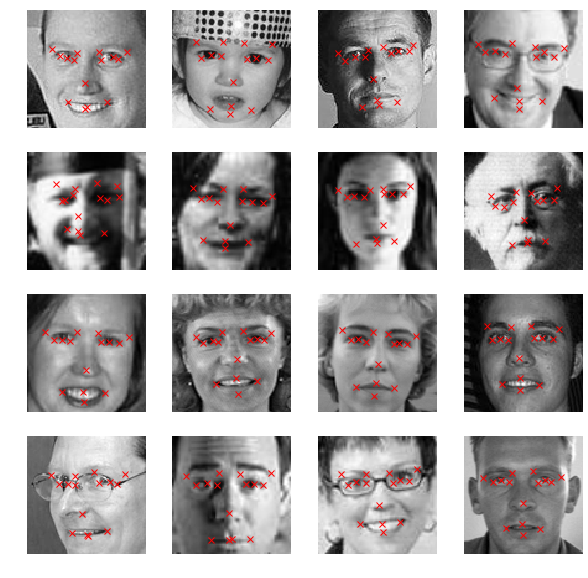

In [44]:
test_data_gah = pd.read_csv('test.csv')

#Convert the images to a manipulable array
test_data_gah['Image'] = test_data_gah['Image'].apply(lambda img:  np.fromstring(img, sep =' '))

#Create an array of the images
test_images_gah = np.vstack(test_data_gah['Image'].values)
#Scale the gray color from 0-1
test_images_gah = test_images_gah / 255.   
test_images_gah = test_images_gah.astype(np.float32)

#Reshape the images to work with the 2D model
test_images2_gah = test_images_gah.reshape(-1, 1, 96, 96)

#Predict the 15 facial keypoints from the test images
pred_test_gah = model3_gah.predict(test_images2_gah)

#Change the predictions back to 96 X 96 arrays
pred_test_gah96 = pred_test_gah*48 + 48

#Create a Dataframe of the predicted data
column_names_gah = data.columns[:-1].tolist()
column_names_gah = column_names_gah[:-1]

test_df_gah = pd.DataFrame(data = pred_test_gah96, columns = column_names_gah)

def plot_random_gah(dataset1, dataset2, nrows, ncols):
    #Plot a random array of faces with markers
    faces_list = np.random.randint(low=0, high=(len(dataset2)-1), size=(nrows*ncols))
    keypoint_names = list(dataset1.columns)
    keypoint_loc = dataset1.loc[faces_list][keypoint_names]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for face, (coord, feature), ax in zip(faces_list, keypoint_loc.iterrows(), axes.ravel()):
        coords = feature.values.reshape((15,2))
        ax.imshow(dataset2[face].reshape(96,96), cmap='gray')
        ax.plot(coords[:, 0], coords[:, 1], 'rx')
        ax.axis('off')
        
plot_random_gah(test_df_gah, test_images2_gah, 4, 4)

Despite the potential for overfitting and using all of the high quality data points for training, the model appears to generalize fairly well to an array of the test images.  Unsurprisingly, the fits are considerably worse on images with multiple faces, of different sizes, and animated.  Another interesting result is the model's underperformance on faces turned at an angle.  This helps explain the earlier result of getting decent accuracy just using average location on each image.

In [45]:
global all_results
all_results = all_results.append({
    'method': 'NN - with convolutions',
    'rmse': 1.88
}, ignore_index=True)

all_results

,method,rmse
0,baseline,3.202738
1,k-nearest regressor,2.679292
2,k-nearest regressor (with blurring),2.666802
3,NN - fully connected,2.790000
4,NN - with convolutions,1.880000


### MLP Perceptron

#### Backward Propogation with L2 and L1 Regularization.

Multi-layer perceptron utilizes activation functions such as Sigmoid and Hyperbolic tangent to activate the Perceptron Neuron. This model optimizes the squared-loss using LBFGS or stochastic gradient descent.

In [46]:
#reformatting data to massage dim constrains on dot products in self-NN class
X_train = np.array([x for x in data['Image_Matrix']], dtype='float')

training = data.drop(columns='Image').drop(columns='Image_Matrix').values
y_train = [y for y in training]
y_train = np.array(y_train, dtype = 'float')

### MLP Perceptron - SGD solver + Logistic activation

Iteration 1, loss = 819.58479685
Iteration 2, loss = 235.34738318
Iteration 3, loss = 69.60265693
Iteration 4, loss = 22.79666318
Iteration 5, loss = 9.93496099
Iteration 6, loss = 6.40563089
Iteration 7, loss = 5.43941238
Iteration 8, loss = 5.17414421
Iteration 9, loss = 5.10085807
Iteration 10, loss = 5.08023837
Iteration 11, loss = 5.07448449
Iteration 12, loss = 5.07313623
Iteration 13, loss = 5.07264246
Iteration 14, loss = 5.07253077
Iteration 15, loss = 5.07262909
Iteration 16, loss = 5.07274268
Iteration 17, loss = 5.07230573
Iteration 18, loss = 5.07227014
Iteration 19, loss = 5.07244357
Iteration 20, loss = 5.07243598
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


,method,rmse
0,baseline,3.202738
1,k-nearest regressor,2.679292
2,k-nearest regressor (with blurring),2.666802
3,NN - fully connected,2.790000
4,NN - with convolutions,1.880000
5,MLP - sgd/logistic,3.184594


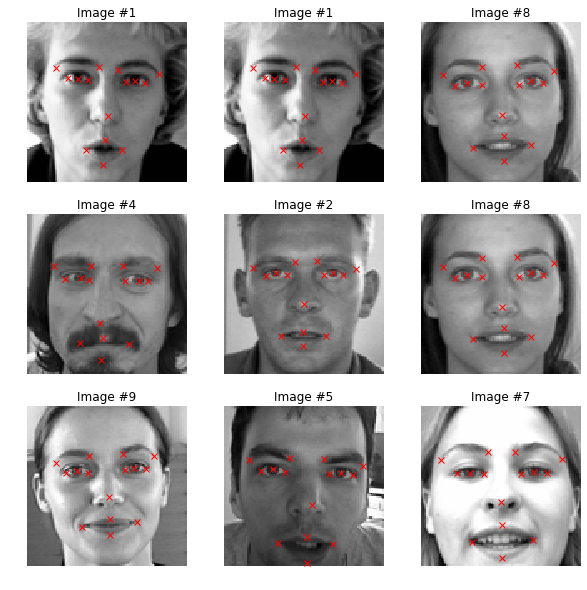

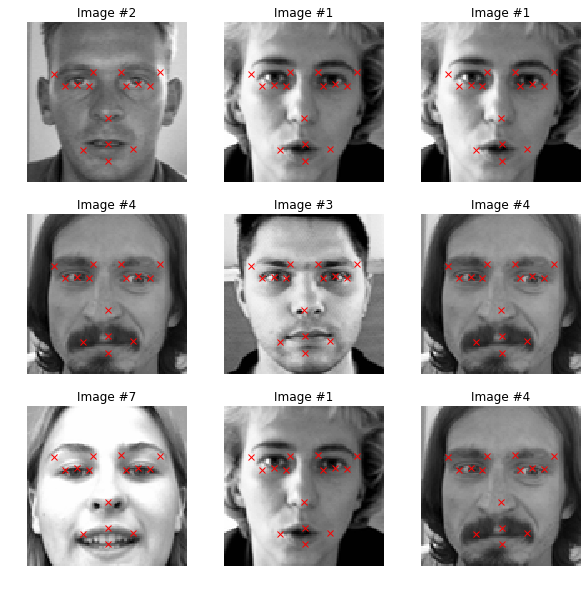

In [47]:
clf_sgd = MLPRegressor(hidden_layer_sizes=(100, ), activation='logistic', solver='sgd', 
                   alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                   power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=True, 
                   warm_start=False, momentum=0.001, nesterovs_momentum=True, early_stopping=False, 
                   validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
clf_sgd.fit(X_train, y_train)

y_train_pred_sdg = clf_sgd.predict(X_train)
plot_random_with_points(
    images=data['Image_Matrix'][:10],
    key_point_arrays=y_train[:10],
    nrows=3,
    ncols=3
)

plot_random_with_points(
    images=data['Image_Matrix'][:10],
    key_point_arrays=y_train_pred_sdg[:10],
    nrows=3,
    ncols=3
)

measure_all('MLP - sgd/logistic', y_train, y_train_pred_sdg)

### MLP Perceptron - LBFGS solver

,method,rmse
0,baseline,3.202738
1,k-nearest regressor,2.679292
2,k-nearest regressor (with blurring),2.666802
3,NN - fully connected,2.790000
4,NN - with convolutions,1.880000
5,MLP - sgd/logistic,3.184594
6,MLP - lbfgs,3.184591


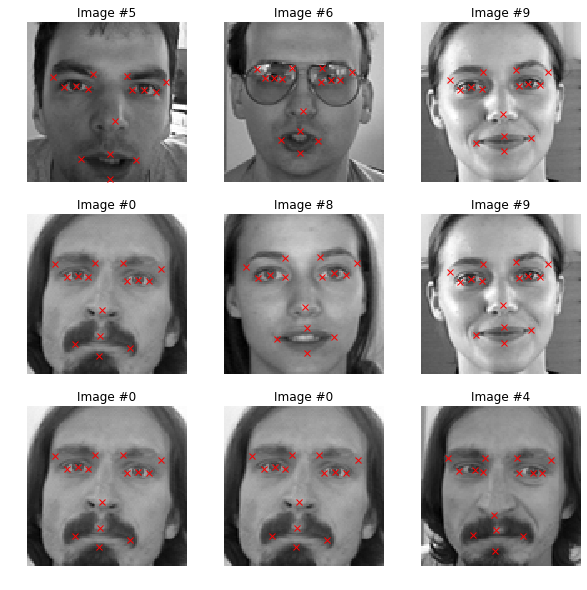

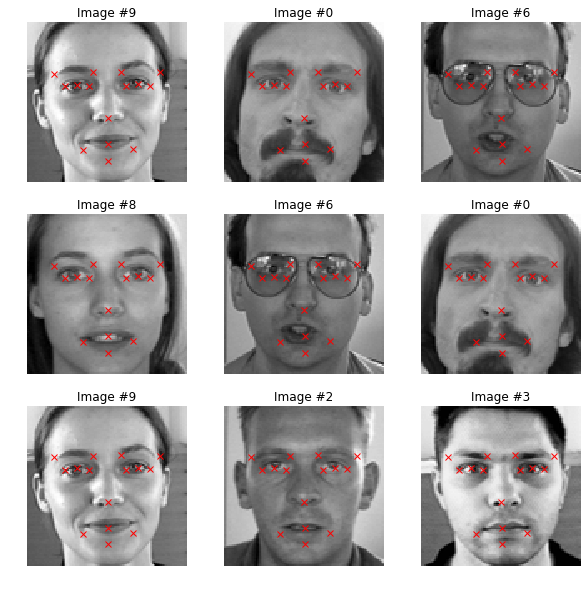

In [50]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5,
                   hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
plot_random_with_points(
    images=data['Image_Matrix'][:10],
    key_point_arrays=y_train[:10],
    nrows=3,
    ncols=3
)


plot_random_with_points(
    images=data['Image_Matrix'][:10],
    key_point_arrays=y_train_pred[:10],
    nrows=3,
    ncols=3
)

measure_all('MLP - lbfgs', y_train, y_train_pred)

### MLP Perceptron - ADAM solver + RELU

Iteration 1, loss = 58268.63548112
Iteration 2, loss = 1309.47417354
Iteration 3, loss = 1309.33548281
Iteration 4, loss = 1425.74552817
Iteration 5, loss = 1308.95601311
Iteration 6, loss = 1308.73515109
Iteration 7, loss = 1308.49857839
Iteration 8, loss = 1308.24904582
Iteration 9, loss = 1307.98801084
Iteration 10, loss = 1307.71707273
Iteration 11, loss = 1307.43712386
Iteration 12, loss = 1307.14899224
Iteration 13, loss = 1306.85332065
Iteration 14, loss = 1306.55081260
Iteration 15, loss = 1306.24194128
Iteration 16, loss = 1305.92716217
Iteration 17, loss = 1305.60670493
Iteration 18, loss = 1305.28120404
Iteration 19, loss = 1304.95072059
Iteration 20, loss = 1304.61564051
Iteration 21, loss = 1304.27618759
Iteration 22, loss = 1303.93265482
Iteration 23, loss = 1303.58510141
Iteration 24, loss = 1303.23375355
Iteration 25, loss = 1302.87899551
Iteration 26, loss = 1302.52069801
Iteration 27, loss = 1302.15913958
Iteration 28, loss = 1301.79444334
Iteration 29, loss = 1301.42

,method,rmse
0,baseline,3.202738
1,k-nearest regressor,2.679292
2,k-nearest regressor (with blurring),2.666802
3,NN - fully connected,2.790000
4,NN - with convolutions,1.880000
5,MLP - sgd/logistic,3.184594
6,MLP - lbfgs,3.184591
7,MLP - adam/relu,10.346938


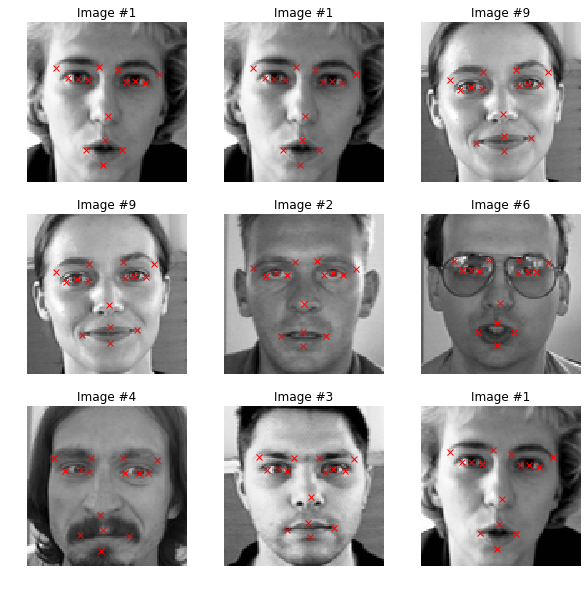

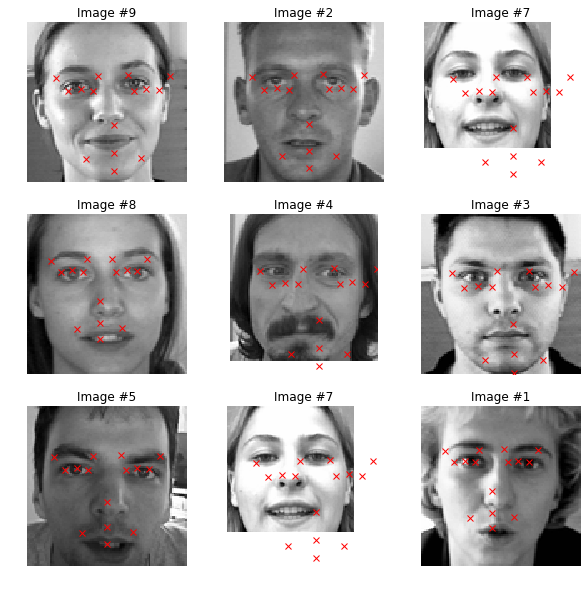

In [52]:
clf_relu = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', 
                   alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001, 
                   power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=True, 
                   warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                   validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

clf_relu.fit(X_train, y_train)
y_train_pred_relu = clf_relu.predict(X_train)
plot_random_with_points(
    images=data['Image_Matrix'][:10],
    key_point_arrays=y_train[:10],
    nrows=3,
    ncols=3
)


plot_random_with_points(
    images=data['Image_Matrix'][:10],
    key_point_arrays=y_train_pred_relu[:10],
    nrows=3,
    ncols=3
)

measure_all('MLP - adam/relu', y_train, y_train_pred_relu)

### Discussion

Multilayer perceptron models chosen, using Relu (the rectified linear unit function, returns f(x) = max(0, x)) and Logistic activation functions performed relatively poorly on the image training set.

This is expected behavior as the problem at hand contains data that is not perfectly linearly seperable. That is there doesn't exist some hyperplane in R2 that seperates all the features. This also creates significant issues for the Relu activation solver as this limits convergence of the weights. As these weights do not converge to reasonable tolerance, the algorithm finds it difficult to classify each point correctly.

The limitations of perceptron become apparent on this dataset. The decision boundaries being only linear limits classification margins. To massage some of these issues, we need to incoporate feature mapping, PCA and feature combinations to reduce the dimensionality of the images and relax decision boundaries. 



## Conclusion

It appears as though the neural network with the convlutional layers performed best when comparing RMSE scores fo the different models:

In [53]:
all_results

,method,rmse
0,baseline,3.202738
1,k-nearest regressor,2.679292
2,k-nearest regressor (with blurring),2.666802
3,NN - fully connected,2.790000
4,NN - with convolutions,1.880000
5,MLP - sgd/logistic,3.184594
6,MLP - lbfgs,3.184591
7,MLP - adam/relu,10.346938


This makes sense because the convolutional filters should capture latent features about images of faces including borders, edges and light/shadowed portions common to different faces. It should also be immune to faces that are artwork or blurred out. Thus, the connected layers after the convolutional layers should capture key-point features without any confounding factors related to images themselves. A limitation is the model could be over-fitted since the data set is restricted to faces of a certain orientation.

Further work could also include predicting certain key points of the face and regressing other key points using those predictions and the source image (as shown in the EDA some key points like left forner of the right eye are strongly correlated to others like the center of right eye and nose).